<h1>CSE483 Computer Vision Major Task</h1>
<h2>Team 1</h2>
<ul>
<li>Youssef George 19p9824</li>
<li>Kerollos Wageeh 19p3468</li>
<li>Nada Amr 19p1621</li>
</ul>

## Import libraries
Use "pip install libName" in terminal if any of them is not installed on your machine.

In [19]:
import pandas as pd
import numpy as np
import cv2
from scipy.io import loadmat
import json
import statistics
import torch
from torchvision import ops
from operator import itemgetter


# for visualization
import matplotlib.pyplot as plt

## Discovering digitalStruct file

In [15]:
with open('SVHN/train/digitStruct.json') as f:
    data = json.load(f)
print(type(data))
print("sample data item:\n", data[0])
print("sample boxes:\n", data[0]['boxes'])
print("each item is of type: ", type(data[0]))
print("each item has 2 keys: ", data[0].keys())
print("each boxes is a", type(data[0]['boxes']), "of: ", len(data[0]['boxes']), type(data[0]['boxes'][0]))
print("first dict has ", data[0]['boxes'][0].keys())
print("second dict has ", data[0]['boxes'][1].keys())
for i in range(len(data)):
    data[i]['filename'] = 'train/'+data[i]['filename']

<class 'list'>
sample data item:
 {'filename': '1.png', 'boxes': [{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}, {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]}
sample boxes:
 [{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}, {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]
each item is of type:  <class 'dict'>
each item has 2 keys:  dict_keys(['filename', 'boxes'])
each boxes is a <class 'list'> of:  2 <class 'dict'>
first dict has  dict_keys(['height', 'label', 'left', 'top', 'width'])
second dict has  dict_keys(['height', 'label', 'left', 'top', 'width'])


## Import Pics with labels

In [17]:
def getPics(chosen_set):
    images = []
    labels = []
    boxes = []
    
    picsFolder_path = "SVHN/" + chosen_set + "/"
    with open(picsFolder_path + 'digitStruct.json') as f:
        data = json.load(f)

# import colored pictures
    for i in range(len(data)):
        image = cv2.imread(picsFolder_path + data[i]['filename'])
        images.append(image)
        temp=[]
        for j in range(len(data[i]['boxes'])):
            temp.append(data[i]['boxes'][j]['label'])
        temp = np.array(temp)
        labels.append(temp)
        boxes.append(data[i]['boxes'])

    print("There are ", len(data), " images in " + chosen_set + " set.")
    images = np.array(images)
    labels = np.array(labels)
    boxes = np.array(boxes)
    return images, labels, boxes

In [18]:
train_images, train_labels, train_boxes = getPics("train")
print(train_boxes[0])

There are  33402  images in train set.
[{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}, {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]


- Calculating images median and mean resolution

In [5]:
sizes = []
for img in train_images:
    sizes.append(img.shape[0]*img.shape[1])
imgs_median_size = statistics.median(sizes)
imgs_mean_size = statistics.mean(sizes)

print("Average image size is:", imgs_mean_size)
print("Median image size is:", imgs_median_size)
print("Min image size is:", min(sizes))
print("Max image size is:", max(sizes))
# plt.hist(sorted(sizes))
plt.show()

Average image size is: 10103.642745943356
Median image size is: 4891.5
Min image size is: 300
Max image size is: 438876


In [20]:
def iouPicTest(truth, predicted, threshold1=0.5, threshold2=0.5):
    iou = [[]*len(predicted)]*len(truth)
    filtered = []
    for i in range(len(truth)):
        for j in range(len(predicted)):
            truth_box = torch.tensor(
                [[truth[i]['left'], truth[i]['top'], truth[i]['left'] + truth[i]['width'],
                  truth[i]['top']+truth[i]['height']]], dtype=torch.float)
            predicted_box = torch.tensor(
                [[predicted[i]['left'], predicted[i]['top'], predicted[i]['left']+predicted[i]['width'],
                  predicted[i]['top']+predicted[i]['height']]], dtype=torch.float)
            iou[i][j] = ops.box_iou(truth_box, predicted_box)
            if (iou[i][j] >= threshold1):
                filtered.append([iou[i][j], predicted_box])

    filtered = sorted(filtered, key=itemgetter(0), reverse=True)

    i=0
    while(filtered[0][1]!=0):
        for j in range(i+1, len(filtered)):
            if (ops.box_iou(filtered[0][1], filtered[j][1])) > threshold2:
                filtered[j][1]=0
        i+=1
        filtered = sorted(filtered, key=itemgetter(0), reverse=True)
    

## Model that get rectangles

In [13]:
def rectanglesModel(img):
    image = img.copy()
    boxes = []
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edged = cv2.Canny(gray, 1, 5, 255)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for i in range(len(contours)):
        boxes.append({})
        boxes[i]['left'], boxes[i]['top'], boxes[i]['width'], boxes[i]['height'] = cv2.boundingRect(contours[i])
    
    # cnts_a = []
    # for c in cnts:
    #     cnts_a.append(cv2.contourArea(c))
    # cnts_m = np.percentile(cnts_a,60)
    # for i in range(len(cnts)):
        # x, y, w, h = cv2.boundingRect(c)
        # if ( img_res < 200 and h >= 10 and h <= 100 and w >= 5 and w <= 50) or (image.shape[0] < 200 and h >= 10 and h <= 100 and w >= 5 and w <= 50):
        #     cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # if(cnts_a[i]>cnts_m):
        #     hull = cv2.convexHull(cnts[i])
        #     cv2.drawContours(image, [hull], 0, (0, 255, 0), 2)
    return boxes

In [14]:
i = 10
image = train_images[i].copy()
predicted_boxes = rectanglesModel(image)
true_boxes = train_boxes[i]
iouPicTest(true_boxes,predicted_boxes)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Label:  [2. 3.]
tensor([[0.2614]])
tensor([[0.2605]])


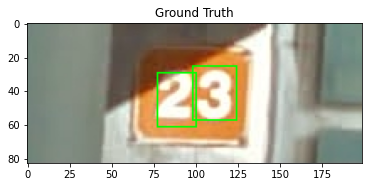

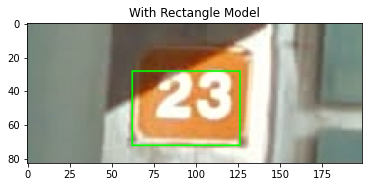

In [8]:
i = 1
train_image = train_images[i].copy()
train_box = train_boxes[i]
print("Label: ", train_labels[i])
# predict rectangles
ans, x, y, w, h = rectangleModel(train_image)
prediction_box = torch.tensor([[x, y, x+w, y+h]], dtype=torch.float)


# preview original image
plt.figure("Ground Truth")
plt.title("Ground Truth")
ground_img = train_image.copy()
for i in range(len(train_box)):
    left = int(train_box[i]['left'])
    top = int(train_box[i]['top'])
    width = int(train_box[i]['width'])
    height = int(train_box[i]['height'])
    ground_box = torch.tensor([[left, top, left+width, top+height]], dtype=torch.float)
    iou = ops.box_iou(ground_box,prediction_box)
    print(iou)
    cv2.rectangle(ground_img,
                  (left, top),
                  (left+width, top+height),
                  (0, 255, 0),
                  1)
plt.imshow(ground_img)

# preview model results
plt.figure("With Rectangle Model")
plt.title("With Rectangle Model")
plt.imshow(ans)
plt.show()


In [9]:
print(iou)

tensor([[0.2605]])


## Model that visualize biggest convex hull

In [10]:
def hullModel(img):
    image = img.copy()
    g = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edged = cv2.Canny(g, 1, 5, 255)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    #cnts = sorted(contours, key=cv2.contourArea, reverse=True)
    hulls = []
    for i in range(len(contours)):
        hulls.append(cv2.convexHull(contours[i]))
        # cv2.drawContours(toDraw, [hull], 0, (0, 255, 0), 1)
    return hulls


Label:  [1. 9.]


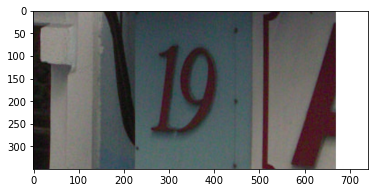

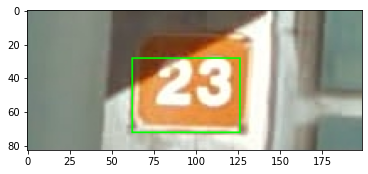

In [11]:
i=0
print("Label: ", train_labels[i])
plt.figure("Original")
plt.imshow(train_images[i])
plt.figure("Hull Model")
hulls = hullModel(train_images[i])
for j in range(len(hulls)):
    toDraw = train_images[i].copy()
    cv2.drawContours(toDraw, [hulls[j]], 0, (0, 255, 0), 1)
    plt.imshow(toDraw)

plt.imshow(ans)


-----------------------------------------------------------------------

- View sample image

In [ ]:
i = 12
print("sample train image of lable(s): ",train_labels[i] )
plt.imshow(train_images[i])
plt.show()

- Convert to grayscale

In [ ]:
gray = cv2.cvtColor(train_images[i],cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

- Gaussian blur

In [ ]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')
plt.show()

- Canny edge detection

In [ ]:
edged = cv2.Canny(gray, 20, 100, 255)
edged_smoothed = cv2.GaussianBlur(edged, (5, 5), 0)

plt.imshow(edged_smoothed, cmap='gray')
plt.show()


- Finding countours

In [ ]:
contours, hierarchy  = cv2.findContours(edged_smoothed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
x = np.zeros((edged.shape[0], edged.shape[1], 3))
for i in range(len(contours)):
    temp = np.zeros((edged.shape[0], edged.shape[1], 3))
    cv2.drawContours(temp, contours, i, (255,255,255), 1, lineType = cv2.LINE_8)
    cv2.drawContours(x, contours, i, (255,255,255), 1, lineType = cv2.LINE_8)
    plt.imshow(temp)
    plt.show()
plt.imshow(x)
plt.show()
x = cv2.convexHull(contours)
plt.imshow(x)
plt.show()

In [ ]:
# find contours in the edge map, then sort them by their size in descending order
# cnts = imutils.grab_contours(contours)
cnts = sorted(contours, key=cv2.contourArea, reverse=True)
img = train_images[i].copy()
i = 0

for j in cnts:
    if (cv2.isContourConvex(j) and i < 4):
        img = cv2.drawContours(img, j, -1, (0, 255, 75), 2)
        print(cv2.contourArea(j))
        i += 1
plt.imshow(img)
plt.show()

# displayCnt = None
# loop over the contours
# for c in cnts:
# 	# approximate the contour
# 	peri = cv2.arcLength(c, True)
# 	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
# 	# if the contour has four vertices, then we have found the thermostat display
# 	if len(approx) == 4:
# 		displayCnt = approx
# 		break


In [ ]:
i = 2
print("sample cropped train image of lable(s): ",cropped_train_labels[i] )
plt.imshow(cropped_train_images[i])
plt.show()

In [ ]:
gray = cv2.cvtColor(cropped_train_images[i],cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

In [ ]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')
plt.show()

In [ ]:
edged = cv2.Canny(blurred, 40, 100, 255)
plt.imshow(edged, cmap='gray')
plt.show()

In [ ]:
for i in range(10):
    plt.imshow(cropped_train_images[i, :, :, :])
    plt.show()
    print(cropped_train_labels[i])